# Import and variables

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
ens_method = "rand_init"
ens_method_ls = [
    "rand_init",
    "bagging",
    "batchensemble",
    "bayesian",
    "mc_dropout",
    "variational_dropout",
    "concrete_dropout",
]
ens_method_labels = {
    "rand_init": "Naive",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.",
    "bayesian": "Bayesian",
    "mc_dropout": "MC Dropout",
    "variational_dropout": "Var. Drop.",
    "concrete_dropout": "Conc. Drop.",
}
dataset_ls = [
    "boston",
    "concrete",
    "energy",
    "kin8nm",
    "naval",
    "power",
    "protein",
    "wine",
    "yacht",
]
dataset_labels = {
    "boston": "Boston \n Housing",
    "concrete": "Concrete \n Strength",
    "energy": "Energy \n Efficiency",
    "kin8nm": "Kin8nm",
    "naval": "Naval \n Propulsion",
    "power": "Power \n Plant",
    "protein": "Protein \n Structure",
    "wine": "Red \n Wine \n Quality",
    "yacht": "Yacht \n Hydrodynamics"
}
agg_labels = {
    "lp": r"$LP$",
    "vi": r"$V_0^=$",
    "vi-a": r"$V_a^=$",
    "vi-w": r"$V_0^w$",
    "vi-aw": r"$V_a^w$",
}

In [11]:
# Get colors
agg_cols = sns.color_palette("Dark2", 8, as_cmap=True)
# Colors of aggregation methods
agg_col = {
    "lp": agg_cols.colors[4],  # type: ignore
    "vi": agg_cols.colors[5],  # type: ignore
    "vi-a": agg_cols.colors[2],  # type: ignore
    "vi-w": agg_cols.colors[0],  # type: ignore
    "vi-aw": agg_cols.colors[3],  # type: ignore
    "ens": agg_cols.colors[7],  # type: ignore
    "opt": agg_cols.colors[1],  # type: ignore
}

greens = sns.color_palette("Greens", 2, as_cmap=False)
blues = sns.color_palette("Blues", 1)
purples = sns.color_palette("Purples", 1)
reds = sns.color_palette("Reds", 3)
ens_col = {
    "rand_init": greens[1], #multi_model_cols.colors[0],  # type: ignore
    "bagging": greens[0], #multi_model_cols.colors[1],  # type: ignore
    "batchensemble": blues[0], #multi_model_cols.colors[3],  # type: ignore
    "bayesian": purples[0], #multi_model_cols.colors[8],  # type: ignore
    "mc_dropout": reds[2], #dropout_cols.colors[14],  # type: ignore
    "variational_dropout": reds[1], #dropout_cols.colors[16],  # type: ignore
    "concrete_dropout": reds[0], #dropout_cols.colors[15],  # type: ignore
}

# KIT colors
kit_cols_dict = {
    "green": "#00876C",  # 26%
    "lightgreen": "#00e6b8",  # 45%
    "blue": "#4664AA",  # 47%
    "lightblue": "#a4b5da",  # 75%
    "black": "#000000",
    "grey": "#404040",
}

# Get and prepare data

In [12]:
df = pd.read_csv("98_single_model_evaluation.csv", sep=";")
df["Diff Mean 100"] = (df["Default MC"] - df["Mean 100"]) / df["Default MC"] * 100
df["Diff Mean 1000"] = (df["Default MC"] - df["Mean 1000"]) / df["Default MC"] * 100
df["Diff N ENS 100"] = (df["Default MC"] - df["N ENS 100"]) / df["Default MC"] * 100
df["Diff N ENS 1000"] = (df["Default MC"] - df["N ENS 1000"]) / df["Default MC"] * 100
df

,Unnamed: 0,Rand Init,Default MC,Mean 1000,Diff Mean 1000,Mean 100,Diff Mean 100,N ENS 100,Diff N ENS 100,N ENS 1000,Diff N ENS 1000
0,boston,1.874762,2.163253,2.049654,5.251304,2.039203,5.734419,2.058698,4.833230,2.041028,5.650056
1,concrete,5.919822,6.255906,6.142405,1.814302,6.221456,0.550680,6.154121,1.627023,6.224521,0.501686
2,energy,1.555607,1.904298,1.801979,5.373056,1.824164,4.208060,1.827598,4.027731,NaN,NaN
3,kin8nm,0.047229,0.069153,0.055888,19.182103,0.053078,23.245557,0.054984,20.489350,NaN,NaN
4,naval,0.001432,0.007666,0.007858,-2.504566,0.007545,1.578398,0.007757,-1.187060,NaN,NaN
5,power,2.407278,6.251255,4.136495,33.829367,5.067972,18.928727,5.140472,17.768960,NaN,NaN
6,protein,2.395475,2.446967,2.439730,0.295754,2.422402,1.003896,2.417892,1.188206,NaN,NaN
7,wine,0.354130,0.390260,0.375880,3.684723,0.371823,4.724286,0.379416,2.778660,NaN,NaN
8,yacht,3.724548,4.096527,2.721831,33.557596,3.910525,4.540480,3.952559,3.514392,NaN,NaN


In [13]:
df_melted = pd.melt(df, id_vars=["Unnamed: 0"], var_name="Variant", value_vars=["Diff Mean 1000", "Diff Mean 100", "Diff N ENS 100", "Diff N ENS 1000"], value_name="CRPS reduction")

In [14]:
df_melted.head()

,Unnamed: 0,Variant,CRPS reduction
0,boston,Diff Mean 1000,5.251304
1,concrete,Diff Mean 1000,1.814302
2,energy,Diff Mean 1000,5.373056
3,kin8nm,Diff Mean 1000,19.182103
4,naval,Diff Mean 1000,-2.504566


# Final plots

In [15]:
agg_colors = {
    "Diff Mean 100": kit_cols_dict["green"],
    "Diff Mean 1000": kit_cols_dict["lightgreen"],
    "Diff N ENS 100": kit_cols_dict["blue"],
    "Diff N ENS 1000": kit_cols_dict["lightblue"],
}

AxesSubplot(0.125,0.11;0.775x0.77)


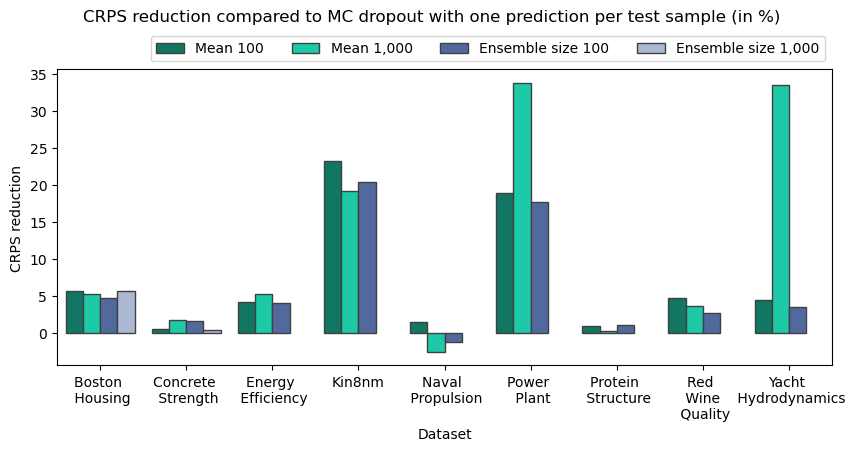

In [16]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

print(ax)

hue_order = ["Diff Mean 100", "Diff Mean 1000", "Diff N ENS 100", "Diff N ENS 1000"]
sns.barplot(df_melted, x="Unnamed: 0", y="CRPS reduction", hue="Variant", edgecolor=kit_cols_dict["grey"], hue_order=hue_order, palette=agg_colors)

curr_handles, curr_labels = ax.get_legend_handles_labels()
ax.legend([],[], frameon=False)
labels = ["Mean 100", "Mean 1,000", "Ensemble size 100", "Ensemble size 1,000"]
ax.set_xticklabels([dataset_labels.get(column_name) for column_name in dataset_ls])
ax.set_xlabel("Dataset")
fig.subplots_adjust(top=0.85)
fig.legend(curr_handles, labels, bbox_to_anchor=(0.9, 0.95), ncol=4)
fig.suptitle("CRPS reduction compared to MC dropout with one prediction per test sample (in %)", y=1)

save_dir = os.path.join("plots", "results")
filename=os.path.join(save_dir, "98_single_model_evaluation.pdf")
fig.savefig(filename, bbox_inches='tight')
filename=os.path.join(save_dir, "98_single_model_evaluation.png")
fig.savefig(filename, bbox_inches='tight')